In [1]:
# default_exp pyfly_fixed_wing_visualizer

# pyfly_fixed_wing_visualizer

> record pyfly-fixed-wing simulations and visualize them. 

> 1. Initialize a recorder Object with the intended simulation duration:
>
>    rec = simrecorder(500)


> 2. Within the simulation loop record each state:
>
> if not success:
>        break
>    else:
>        rec.savestate(sim.state, step_i)


> 3. After the simulation call the plot fuction:
>
> rec.plot()

In [2]:
#hide 
from nbdev.showdoc import *
import os
if not 'notebookDir' in globals():
    notebookDir = os.getcwd()
print('notebookDir: ' + notebookDir)

notebookDir: /home/user/Dokumente/#master/Sem_03/ALDR_GIT/tum-adlr-ws20-08/magpie/libs/pyfly-fixed-wing-visualizer


In [7]:
#export 
class simrecorder:
   
    
    class prog():
        '''
        Progressbar class. Used for displaying the progress during simulation and rendering. Requires tqdm.
        '''
        def __init__(self,max_it, name, unit, pos):
            from tqdm import tqdm
            self.bar = tqdm(total=max_it, position=pos, leave=True, unit=unit, desc=name)
            
        def update(self,val):
            self.bar.update(val)
            
        def disable(self):
            self.bar.disable=True
    
    def __init__(self, simduration):
        '''
        Initialize main class, used for recording, plotting
        '''
        import numpy as np
        self.simduration = simduration # In sim.dt steps
        self.simpb = self.prog(simduration,'Simulating',' Step',0) # progressbar for simulation
    
        ## Arrays used for storing simulation results
        self.res_n = np.zeros(simduration)
        self.res_e = np.zeros(simduration)
        self.res_d = np.zeros(simduration)
        self.roll = np.zeros(simduration)
        self.pitch = np.zeros(simduration)
        self.yaw = np.zeros(simduration)
        self.wind_n = np.zeros(simduration)
        self.wind_e = np.zeros(simduration)
        self.wind_d = np.zeros(simduration)


    def reset(self, simduration=None):
        """
        Reset main class, used for recording, plotting
        """
        import numpy as np

        if simduration == None:
            simduration = self.simduration
        else:
            self.simduration = simduration

        self.simpb = self.prog(
            simduration, "Simulating", " Step", 0
        )  # progressbar for simulation

        ## Arrays used for storing simulation results
        self.res_n = np.zeros(simduration)
        self.res_e = np.zeros(simduration)
        self.res_d = np.zeros(simduration)
        self.wind_n = np.zeros(simduration)
        self.wind_e = np.zeros(simduration)
        self.wind_d = np.zeros(simduration)
        self.roll = np.zeros(simduration)
        self.pitch = np.zeros(simduration)
        self.yaw = np.zeros(simduration)
        
    
    def savestate(self, state, idd):
        '''
        This function is called every step of the simulation 
        and passed simulation object as well as the current simulation step
        '''
        self.res_n[idd] = state['position_n'].value
        self.res_e[idd] = state['position_e'].value
        self.res_d[idd] = -state['position_d'].value
        self.wind_n[idd] = state['wind_n'].value
        self.wind_e[idd] = state['wind_e'].value
        self.wind_d[idd] = state['wind_d'].value
        self.roll[idd] = state['roll'].value
        self.pitch[idd] = state['pitch'].value
        self.yaw[idd] = state['yaw'].value
        
        self.simpb.update(1) # Update progressbar
        
    def read_obj(self, filename):
        '''
        from https://gist.github.com/yzhong52/7c3e0b3a201af45f0cd12f10e06b9d95
        load a .obj file into triangles and vertices
        '''
        import numpy as np

        triangles = []
        vertices = []
        with open(filename) as file:
            for line in file:
                components = line.strip(' \n').split(' ')
                if components[0] == "f": # face data
                    # e.g. "f 1/1/1/ 2/2/2 3/3/3 4/4/4 ..."
                    indices = list(map(lambda c: int(c.split('/')[0]) - 1, components[1:]))
                    for i in range(0, len(indices) - 2):
                        triangles.append(indices[i: i+3])
                elif components[0] == "v": # vertex data
                    # e.g. "v  30.2180 89.5757 -76.8089"
                    vertex = list(map(lambda c: float(c), components[1:]))
                    vertices.append(vertex)
        return np.array(vertices), np.array(triangles)

    
    
    def rotation_matrix(self, axis, theta):
        import math
        import numpy as np
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        axis = np.asarray(axis)
        axis = axis / math.sqrt(np.dot(axis, axis))
        a = math.cos(theta / 2.0)
        b, c, d = -axis * math.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    
    
        
    def plot(self, rotate=180, interval = 10, render = 'notebook', epoch = None):
        '''
        Main plotting functions accepting the following optional parameters:
            - rotate: azimuth rotation of final 3D plot.
            - interval: 
        '''
        from IPython.core.display import HTML
        import matplotlib.pyplot as plt
        import mpl_toolkits.mplot3d.axes3d as p3
        import matplotlib.animation as animation        
        import numpy as np


        self.fig = plt.figure(figsize=(10,10))
        self.fig.suptitle('')

        data = [self.res_n, self.res_e, self.res_d]

        self.ax = self.fig.add_subplot(1, 1, 1, projection='3d')
        self.ax.set_xlim3d([np.min(data)-2,np.max(data)+2])
        self.ax.set_xlabel('X')
        self.ax.set_ylim3d([np.min(data)-2,np.max(data)+2])
        self.ax.set_ylabel('Y')
        self.ax.set_zlim3d([np.min(data)-2,np.max(data)+2])
        self.ax.set_zlabel('Z')


        self.ax.set_title('')  #TODO: self needed here (see update_lines)?


        #load drone 3D model
        vertices, self.triangles = self.read_obj(notebookDir + "/Wing.obj")

        # scaling drone 3D model (this is currently at an arbitrary scale)
        self.drone_x = vertices[:,0]*0.15*0.1
        self.drone_y = vertices[:,1]*0.15*0.1
        self.drone_z = vertices[:,2]*0.15*0.1

        #Rotate Drone into correct initial orientation
        done = np.dot(self.rotation_matrix([0,0,1], np.pi/2), [self.drone_x,self.drone_y,self.drone_z])
        done = np.dot(self.rotation_matrix([1,0,0], np.pi/2), done)
        [self.drone_x,self.drone_y,self.drone_z] = np.dot(self.rotation_matrix([0,1,0], np.pi), done)

        self.drone=[self.drone_x,self.drone_y,self.drone_z]

      

        lines=[0]

        lines[0], = self.ax.plot(data[0][0:1], data[1][0:1], data[2][0:1],c='orange')
        
        self.trajectory = self.ax.plot(data[0][0:1], data[1][0:1], data[2][0:1],c='green')



        # Creating the Animation object
        self.pb = self.prog(500, 'Drawing', ' Frame',0)
        
        
        self.wind_x, self.wind_y, self.wind_z = np.meshgrid(np.arange(-100, 100, 40),
                                                     np.arange(-100, 100, 40),
                                                     np.arange(-100, 100, 50))
        
        
        
        
        if render == 'notebook':

        
            anim = animation.FuncAnimation(self.fig, self.update_lines, 500, fargs=(data, lines, rotate),
                                               interval=interval, blit=False)

        
            return HTML(anim.to_html5_video())
        
        else:
            import subprocess
            import glob
            import cv2
            import os
            import datetime
            
            
            img_array = []
            
            ##INSERT CODE TO GET xdata and ydata!
            for i in range(0, 500):
                
                lines =self.update_lines(i, data, lines, rotate)
                
                fileName = "videoName"+"%04d.png" % i

                self.fig.savefig('./temp/'+fileName, dpi=250)
                plt.close()  
                

            for i in sorted(glob.glob('./temp/*.png')):
                img = cv2.imread(i)
                height, width, layers = img.shape
                size = (width,height)

                img_array.append(img)
                print(i)
                
                
            
            
            if epoch == None:
                epoch = '???'
            
            name = 'Msac__' + datetime.date.today().strftime("%I_%M%p__%B_%d_%Y") + str(epoch) + '.avi'

            out = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'DIVX'), 20, size)

            for i in range(len(img_array)):
                print(i)
                out.write(img_array[i])
            out.release()

            files = glob.glob("./temp/*")
            for f in files:
                os.remove(f)

    
    # Calculates Rotation Matrix given euler angles.
    def eulerAnglesToRotationMatrix(self, theta) :
        import math
        import numpy as np
        R_x = np.array([[1,         0,                  0                   ],
                        [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                        [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                        ])



        R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                        [0,                     1,      0                   ],
                        [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                        ])

        R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                        [math.sin(theta[2]),    math.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])


        R = np.dot(R_z, np.dot( R_y, R_x ))

        return R
    
    
    def update_lines(self, num, dataLines, lines, rotate):
        import numpy as np
        self.pb.update(1)

        if num == 0:
            
            print(self.trajectory)
            
            self.trajectory[0].set_data([dataLines[0][0],dataLines[0][0]+100],[dataLines[1][0],dataLines[1][0]])

            self.trajectory[0].set_3d_properties([dataLines[2][0],dataLines[2][0]])
            
            
            drone = np.dot(self.eulerAnglesToRotationMatrix([0,0,0]), self.drone)
            self.ax.plot_trisurf(drone[0]+dataLines[0][0]+100, drone[2]+dataLines[1][num], self.triangles, drone[1]+dataLines[2][-1], shade=True,alpha = 0.5, color='green')
            
        for line in lines:

            if len(self.ax.collections) and num >0:
                self.ax.collections.pop() ##remove prior plane
                self.ax.collections.pop() ##remove prior wind
        #    if num ==1:
        #        self.ax.collections.pop() ##remove prior plane
        #        self.ax.collections.pop()

            wind_u = np.ones_like(self.wind_x)*self.wind_n[num]*20
            wind_v = np.ones_like(self.wind_x)*self.wind_e[num]*20
            wind_w = np.ones_like(self.wind_x)*self.wind_d[num]*20

            self.ax.quiver(self.wind_x, self.wind_y, self.wind_z, wind_u, wind_v, wind_w, linewidth = 2 )


            line.set_data(dataLines[0][:num],dataLines[1][:num])

            line.set_3d_properties(dataLines[2][:num])

            drone = np.dot(self.eulerAnglesToRotationMatrix([self.roll[num],self.yaw[num],self.pitch[num]]), self.drone)

            self.ax.plot_trisurf(drone[0]+dataLines[0][num], drone[2]+dataLines[1][num], self.triangles, drone[1]+dataLines[2][num], shade=True, color='red')
            self.ax.view_init(elev=15., azim=45+rotate*num/self.simduration) # 15, 45
                
        return lines
    

In [8]:
import os
if not 'notebookDir' in globals():
    notebookDir = os.getcwd()
print('notebookDir: ' + notebookDir)
os.chdir(notebookDir)
pyfly_dir = notebookDir + "/../pyfly/pyfly/"
print(pyfly_dir)

notebookDir: /home/user/Dokumente/#master/Sem_03/ALDR_GIT/tum-adlr-ws20-08/magpie/libs/pyfly-fixed-wing-visualizer
/home/user/Dokumente/#master/Sem_03/ALDR_GIT/tum-adlr-ws20-08/magpie/libs/pyfly-fixed-wing-visualizer/../pyfly/pyfly/


In [9]:
from pyfly.pyfly import PyFly
from pyfly.pid_controller import PIDController
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation



sim = PyFly(pyfly_dir + "pyfly_config.json", pyfly_dir + "x8_param.mat")
sim.seed(0)
sim.reset(state={"roll": -0.5, "pitch": 0.15, "Wind": 3})
sim.turbulence = True
sim.turbulence_intensity = 'severe'

Simulating: 100%|█████████▉| 499/500 [00:06<00:00, 77.02 Step/s]

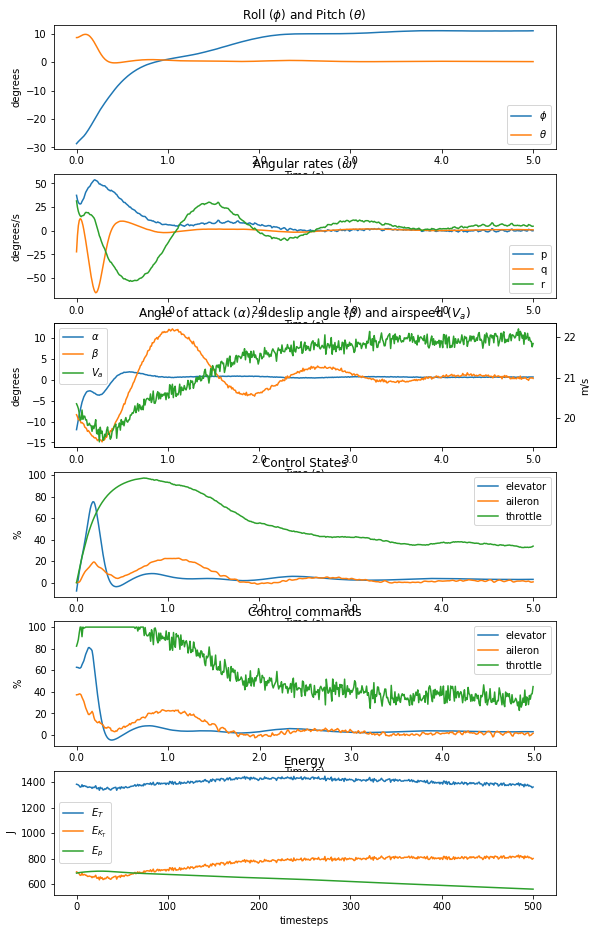

Drawing:   0%|          | 0/500 [00:00<?, ? Frame/s]

Drawing: 100%|██████████| 500/500 [04:35<00:00,  2.10 Frame/s]s]

./temp/videoName0000.png
./temp/videoName0001.png
./temp/videoName0002.png
./temp/videoName0003.png
./temp/videoName0004.png
./temp/videoName0005.png
./temp/videoName0006.png
./temp/videoName0007.png
./temp/videoName0008.png
./temp/videoName0009.png
./temp/videoName0010.png
./temp/videoName0011.png
./temp/videoName0012.png
./temp/videoName0013.png
./temp/videoName0014.png
./temp/videoName0015.png
./temp/videoName0016.png
./temp/videoName0017.png
./temp/videoName0018.png
./temp/videoName0019.png
./temp/videoName0020.png
./temp/videoName0021.png
./temp/videoName0022.png
./temp/videoName0023.png
./temp/videoName0024.png
./temp/videoName0025.png
./temp/videoName0026.png
./temp/videoName0027.png
./temp/videoName0028.png
./temp/videoName0029.png
./temp/videoName0030.png
./temp/videoName0031.png
./temp/videoName0032.png
./temp/videoName0033.png
./temp/videoName0034.png
./temp/videoName0035.png
./temp/videoName0036.png
./temp/videoName0037.png
./temp/videoName0038.png
./temp/videoName0039.png


./temp/videoName0329.png
./temp/videoName0330.png
./temp/videoName0331.png
./temp/videoName0332.png
./temp/videoName0333.png
./temp/videoName0334.png
./temp/videoName0335.png
./temp/videoName0336.png
./temp/videoName0337.png
./temp/videoName0338.png
./temp/videoName0339.png
./temp/videoName0340.png
./temp/videoName0341.png
./temp/videoName0342.png
./temp/videoName0343.png
./temp/videoName0344.png
./temp/videoName0345.png
./temp/videoName0346.png
./temp/videoName0347.png
./temp/videoName0348.png
./temp/videoName0349.png
./temp/videoName0350.png
./temp/videoName0351.png
./temp/videoName0352.png
./temp/videoName0353.png
./temp/videoName0354.png
./temp/videoName0355.png
./temp/videoName0356.png
./temp/videoName0357.png
./temp/videoName0358.png
./temp/videoName0359.png
./temp/videoName0360.png
./temp/videoName0361.png
./temp/videoName0362.png
./temp/videoName0363.png
./temp/videoName0364.png
./temp/videoName0365.png
./temp/videoName0366.png
./temp/videoName0367.png
./temp/videoName0368.png


In [10]:
sim.seed(0)

#sim.reset(state={"roll": -0.5, "pitch": 0.15})
pid = PIDController(sim.dt)
pid.set_reference(phi=0.2, theta=0, va=22)


rec = simrecorder(500)

#sim.reset(state={"roll": -0.5, "pitch": 0.15, "Wind": 1})

for step_i in range(500):
    phi = sim.state["roll"].value
    theta = sim.state["pitch"].value
    Va = sim.state["Va"].value
    omega = [sim.state["omega_p"].value, sim.state["omega_q"].value, sim.state["omega_r"].value]
    action = pid.get_action(phi, theta, Va, omega)
    success, step_info = sim.step(action)

    if not success:
        break
    else:
        rec.savestate(sim.state, step_i)


sim.render(block=True)
rec.plot(rotate=45, render = 'other')


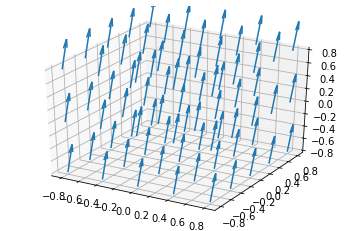

In [11]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.4),
                      np.arange(-0.8, 1, 0.4),
                      np.arange(-0.8, 1, 0.8))

u = np.zeros_like(z)
v = np.ones_like(z)
w = np.ones_like(z)*4

ax.quiver(x, y, z, u, v, w, length=0.1)

plt.show()